## Setup

In [ ]:
# For Google Collab

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [ ]:
!pip install google-colab

Defaulting to user installation because normal site-packages is not writeable
  Using cached google_colab-1.0.0-py2.py3-none-any.whl
  Using cached tornado-4.5.3-cp38-cp38-linux_x86_64.whl
  Using cached portpicker-1.2.0-py3-none-any.whl
  Using cached requests-2.21.0-py2.py3-none-any.whl (57 kB)
  Using cached google_auth-1.4.2-py2.py3-none-any.whl (64 kB)
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached notebook-5.2.2-py2.py3-none-any.whl (8.0 MB)
  Using cached ipython-5.5.0-py3-none-any.whl (758 kB)
  Using cached ipykernel-4.6.1-py3-none-any.whl (104 kB)
  Using cached six-1.12.0-py2.py3-none-any.whl (10 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached prompt_toolkit-1.0.18-py3-none-any.whl (245 kB)
  Using cached simplegeneric-0.8.1-py3-none-any.whl
  Using cached urllib3-1.24.3-py2.py3-none-any.whl (118 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets

from torch.utils.data import Dataset, DataLoader

from google.colab import files

import time
torch.backends.cudnn.deterministic=True


from google.colab import drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
# Create this file if it does not exist in google drive
MODEL_PATH = '/content/gdrive/My Drive/draw_weights'

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Data

In [0]:
class DrawDataManager:
    def __init__(self, dataset='SVHN', data_transforms=None, batch_size=64):
        self.dataset = dataset
        if batch_size%8 != 0 :
            raise ValueError('Choose a perfect square batch size')
        self.batch_size = batch_size
        self.fig = {'train': [], 'test': []}
        
        if data_transforms == None:
            data_transforms = transforms.Compose([transforms.ToTensor()])
            
        if dataset == 'FashionMNIST':
            self.train_set = datasets.FashionMNIST('../fmnist/', download=True, transform=data_transforms)
        elif dataset == 'MNIST':
            self.train_set = datasets.MNIST('../mnist/', download=True, transform=data_transforms)
        elif dataset == 'SVHN':
            self.train_set = datasets.SVHN('../svhn/', download=True, transform=data_transforms)
        else:
            raise ValueError('Dataset not supported')
            
    def dataloader(self):
        if self.batch_size%8 != 0 :
            # TODO: test if I still need this condition with make_grid. 
            raise ValueError('batch size must be divisible by 8')
        return DataLoader(self.train_set, batch_size=self.batch_size)
    
    """
    Images of size (batch_size, num_channels, A, B)
    """
    def plot_batch_images(self, images, log=False, key='train'):
        # We want to plot a Dx8 grid of predictions
        grid_images = torchvision.utils.make_grid(images)
        figure, ax = plt.subplots(1)
        if(grid_images.shape[0] == 3):
            grid_images = grid_images.permute(1, 2, 0)
        ax.imshow(grid_images)
        ax.set_axis_off()
        if log == True:
            if key in self.fig :
                self.fig[key].append(figure)
            else:
                self.fig[key] = [].append(figure)
                
    
    def save_figure(self, it_index = None, key='train', path='.', format='eps'):
        if it_index is None:
            it_index = len(self.fig[key])-1
        fig_name = self.dataset + '_' + key + '_' + str(it_index) + '.' + format
        self.fig[key][it_index].savefig(fig_name, path=path, format=fomart, bbox_inches='tight')


## Network

In [0]:
class DrawNetwork(nn.Module):
    def __init__(self, T, image_size, nb_h, nb_z, batch_size, N=12, attention=False):
        super().__init__()
        
        # Number of timesteps
        self.T = T
        # Grid size for attention
        self.N = N
        # Dimensions of input image
        self.num_channels = image_size[0]
        self.A = image_size[1]
        self.B = image_size[2]
        self.d_image = self.num_channels * self.A * self.B
        
        # LSTM number of hidden layers (nb_h) and number of drawn samples from Q & P (nb_z)
        self.nb_h = nb_h
        self.nb_z = nb_z
        
        # Batch size
        self.batch_size = batch_size
        self.attention = attention
        # Numerical stability constant
        self.epsilon = torch.tensor(1e-8,dtype=torch.float).to(device)
        
        # Read and Write operations according to attention parameter
        if attention == True:
            self.read = self.read_with_attention
            self.write = self.write_with_attention
            self.patch_size = self.num_channels*self.N**2  # patch dimension is NxN
        else:
            self.read = self.read_no_attention
            self.write = self.write_no_attention
            self.patch_size = self.d_image  # patch dimension is same as input image
        
        # Create encoder and decoder networks
        self.rnn_enc = nn.LSTMCell(2 * self.patch_size + nb_h, nb_h)
        self.rnn_dec = nn.LSTMCell(nb_z, nb_h)
        
        # List to store μ & σ at each time step (needed to compute L_z)
#         self.mu = torch.zeros(time_steps, batch_size, latent_size).to(device)
#         self.sigma = torch.zeros(time_steps, batch_size, latent_size).to(device)
        
        self.mu = [0]*(T+1)
        self.sigma = [0]*(T+1)
        
        # Feedforward neural networks to compute μ & log σ
        self.compute_mu = nn.Linear(nb_h, nb_z)
        self.compute_log_sigma = nn.Linear(nb_h, nb_z)
        self.compute_write = nn.Linear(nb_h, self.patch_size)
        
        # Neural networks for attention params
        self.w_read = nn.Linear(nb_h, 5)  # 5 params
        self.w_write = nn.Linear(nb_h, 5)  # 5 params
        
    
    def get_filterbanks(self, h_dec, W):
        # Creating filters
        gt_x, gt_y, log_sigma, log_delta_tilde, log_gamma = W(h_dec).split(1,dim=1)
        # Input of size (A, B)
        A = self.A
        B = self.B
        N = self.N
        # Constant for N - 1 
        N_1 =  N-1
        
        g_x = 0.5 * (A + 1) * (gt_x + 1)
        g_y = 0.5 * (B + 1) * (gt_y + 1)
        
        sigma_squared = torch.exp(2*log_sigma)

        # Reshaping var for broadcasting
        two_times_var = (2*sigma_squared).reshape([-1,1,1])
        
        delta = (max(A,B)- 1)*torch.exp(log_delta_tilde)/N_1
        gamma = torch.exp(log_gamma)
        # Setting the dtype to float to avoid conflicts between tensors
        dtype = torch.float

        im_x_idx = torch.arange(A, dtype=dtype, device=device).reshape([1,1,-1])
        im_y_idx = torch.arange(B, dtype=dtype, device=device).reshape([1,1,-1])

        patch_idx = torch.arange(N, dtype=dtype, device=device)

        mu_x = torch.zeros((self.batch_size, N), device=device)
        mu_y = torch.zeros((self.batch_size, N), device=device)

        F_x = torch.zeros((self.batch_size, N, A), device=device)
        F_y = torch.zeros((self.batch_size, N, B), device=device)


        mu_x = g_x + (patch_idx - 0.5*N - 0.5) * delta
        mu_y = g_y + (patch_idx - 0.5*N - 0.5) * delta

        # Reshaping mu_x and mu_y for broadcasting
        mu_x = mu_x.reshape([-1,N,1])
        mu_y = mu_y.reshape([-1,N,1])

        # Calculating unormalized F_x and F_y
        F_x = torch.exp(-(im_x_idx - mu_x)**2 / two_times_var)
        F_y = torch.exp(-(im_y_idx - mu_y)**2 / two_times_var)

        # Normalizing F_x and F_y
        # It is safe to add epsilon since F_x and F_y are > 0
        F_x = F_x / (F_x.sum(dim=2).reshape([self.batch_size,-1,1]) + self.epsilon)
        F_y = F_y / (F_y.sum(dim=2).reshape([self.batch_size,-1,1]) + self.epsilon)

        return F_x, F_y, gamma
        
    # Read & Write with attention
    def read_with_attention(self, x, x_hat_t, h_dec_t_minus_1):
        F_x, F_y, gamma = self.get_filterbanks(h_dec_t_minus_1, self.w_read)

        F_y = F_y.transpose(1, 2)
        
        F_x = torch.cat([F_x] * self.num_channels, dim=0)
        F_y = torch.cat([F_y] * self.num_channels, dim=0)
        
        # same F applied to all channels so no need to do any manipulation.
        x_shape = (self.batch_size*self.num_channels, self.A, self.B)
        Fx_x_Fy = F_x.bmm(x.reshape(x_shape).transpose(-1, -2)).bmm(F_y).reshape((self.batch_size, -1))
        Fx_xh_Fy = F_x.bmm(x_hat_t.reshape(x_shape).transpose(-1, -2)).bmm(F_y).reshape((self.batch_size, -1))
        gamma = gamma.reshape([-1,1])
        
        # Over dimension 1 because we don't want to change the dim 0 to 2*batch size.
        return (gamma*torch.cat([Fx_x_Fy, Fx_xh_Fy], dim=1))
        
        
    def write_with_attention(self, h_dec_t):
        w = self.compute_write(h_dec_t).reshape((self.batch_size*self.num_channels, self.N, self.N))
      
        F_x, F_y, gamma = self.get_filterbanks(h_dec_t, self.w_write)
        
        F_x = F_x.transpose(1, 2)
        
        F_x = torch.cat([F_x] * self.num_channels, dim=0)
        F_y = torch.cat([F_y] * self.num_channels, dim=0)
        
        gamma = gamma.reshape([-1,1])
        
        Fx_w_Fy = F_x.bmm(w).bmm(F_y).reshape([self.batch_size,-1])
        
        return Fx_w_Fy / gamma
        
    # Read & Write without attention
    def read_no_attention(self, x, x_hat_t, h_dec_t_minus_1):
        return torch.cat([x, x_hat_t], 1)
      
        
    def write_no_attention(self, h_dec_t_minus_1):
        return self.compute_write(h_dec_t_minus_1)
        
        
    # Sample from P & Q
    def sample_from_P(self):
        random_normal_sample = torch.randn(self.batch_size, self.nb_z).to(device)
        return random_normal_sample
      
    def sample_from_Q(self, h_enc_t, t):
        random_normal_sample = torch.randn(self.batch_size, self.nb_z).to(device)
        
        # Need to store those values to compute L_z
        self.mu[t] = self.compute_mu(h_enc_t)
        self.sigma[t] = torch.exp(self.compute_log_sigma(h_enc_t))
        
        return random_normal_sample*self.sigma[t] + self.mu[t]
  
  
    # Forward
    
    def forward(self, x):
        # Flatten x
        x = x.view(self.batch_size, -1)
        
        # x_hat
        x_hat = [0] * (self.T + 1)
        
        # r
        r = [0] * (self.T + 1)
        
        # z
        z = [0] * (self.T + 1)
        
        # h^enc & c_enc
        h_enc = [0] * (self.T + 1)
        h_enc[0] =torch.zeros(self.batch_size, self.nb_h).to(device)
        
        c_enc = [0] * (self.T + 1)
        c_enc[0] = torch.zeros(self.batch_size, self.nb_h).to(device)
        
        # h^dec & c_dec
        h_dec = [0] * (self.T + 1)
        h_dec[0] = torch.zeros(self.batch_size, self.nb_h).to(device)
        
        c_dec = [0] * (self.T + 1)
        c_dec[0] = torch.zeros(self.batch_size, self.nb_h).to(device)
        
        # List to store generate images at each time step
        c = [0] * (self.T + 1)
        
        # Initialize c[0] (black image)
        c[0] = torch.zeros(self.batch_size, self.d_image).to(device)
        
        for t in range(1, self.T + 1):
            x_hat[t] = x - torch.sigmoid(c[t-1])
            
            r[t] = self.read(x, x_hat[t], h_dec[t-1])
            
            h_enc[t], c_enc[t] = self.rnn_enc( torch.cat( (r[t], h_dec[t-1]), 1 ), (h_enc[t-1], c_enc[t-1]) )
            
            z[t] = self.sample_from_Q(h_enc[t], t)
            
            h_dec[t], c_dec[t] = self.rnn_dec( z[t], (h_dec[t-1], c_dec[t-1]) )
            
            c[t] = c[t-1] + self.write(h_dec[t])
            
        return c[self.T]
    
    
    # Compute the loss
    
    def compute_loss(self, x):
        c_T = self.forward(x)
        x = x.view(x.size(0), -1)
        
        # Compute L^x 
        loss = nn.BCELoss(reduction="sum")
        # We want the loss per image and not per pixel value
        L_x = loss(torch.sigmoid(c_T), x) / self.batch_size
        
        # Compute L^z
        L_z = 0
        
        for t in range(1, self.T + 1):
            L_z += 0.5 * torch.sum(self.mu[t]**2 + self.sigma[t]**2 - 2*torch.log(self.sigma[t]), 1) - 0.5

        # Return Expectation of both sums
        return L_x + torch.mean(L_z)
            
        
    # Generate images - This should have nothing to do with grads
    def generate_images(self):
        # z
        z = [0] * (self.T + 1)
        
        # h^dec & c_dec
        h_dec = [0] * (self.T + 1)
        h_dec[0] = torch.zeros(self.batch_size, self.nb_h).cuda()
        
        c_dec = [0] * (self.T + 1)
        c_dec[0] = torch.zeros(self.batch_size, self.nb_h).cuda()
              
        # List to store generate images at each time step
        c = [0] * (self.T + 1)
        
        # Initialize c[0] (black image)
        c[0] = torch.zeros(self.batch_size, self.d_image).cuda()
        
        for t in range(1, self.T + 1):
            
            z[t] = self.sample_from_P()
            
            h_dec[t], c_dec[t] = self.rnn_dec( z[t], (h_dec[t-1], c_dec[t-1]) )
            
            c[t] = c[t-1] + self.write(h_dec[t])
            
        return torch.sigmoid(torch.stack(c))


## Model

In [0]:
class DrawModel:
    def __init__(self, network, dataset='SVHN'):
        self.data_manager = DrawDataManager(dataset=dataset)
        self.model = network
        self.optimizer = optim.Adam(self.model.parameters())
    def train(self, nb_epochs):
        generated_images = []
        empirical_risks = []
        train_loader = self.data_manager.dataloader()
        
        start_time = time.time()
        for epoch in range(nb_epochs):
            empirical_risk = 0                        
            print('Epoch', epoch+1)
            
            for X_batch, _ in train_loader:
                # MNIST : 60k, 60k % 64 != 0
                if len(X_batch) != self.model.batch_size:
                    break
                    
                # Reset the gradients to zero
                self.optimizer.zero_grad()
                
                # Send the batch to the GPU
                X_batch = X_batch.to(device)
                
                # Compute loss
                loss = self.model.compute_loss(X_batch)
            
                # Sum losses to eventually compute empirical risk
                empirical_risk += loss.item()

                # Backward propagation
                loss.backward()
                
                # Update weights
                self.optimizer.step()

            # Empirical risk calculation
            empirical_risk = empirical_risk/len(train_loader)
            print('empirical risk:', empirical_risk)
                
            empirical_risks.append(empirical_risk)  
            
            if min(empirical_risks) > empirical_risk:
                torch.save(self.model.state_dict(), save_path)
            # Deactivating grad tracking for image generation:
            with torch.no_grad():
                generated_images.append(self.model.generate_images())
            
            #Save model after each epoch
            
            if epoch%10 == 0:
                self.save_model()
            
            run_time = time.time() - start_time
            print('runtime:',run_time/60,'mins')
            
        return empirical_risks, generated_images
    
    def save_model(self, save_path=MODEL_PATH):
        state = {
            'model_state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        save_path += '/' + self.data_manager.dataset + "_" + \
        str(self.model.attention) + '_' + \
        str(self.model.nb_h) + '_' + \
        str(self.model.nb_z) + '_' + \
        str(self.model.N) + '_states'
        torch.save(state, save_path)
    
    def load_model(self, save_path=MODEL_PATH):
        """
        save_path += '/' + self.data_manager.dataset + "_" + \
        str(self.model.attention) + '_' + \
        str(self.model.nb_h) + '_' + \
        str(self.model.nb_z) + '_' + \
        str(self.model.N) + '_states'
        """
        checkpoint = torch.load(save_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])

# Plotting function

In [0]:
def plot_images(imgs, img_height, img_width, plot_title, attention=False, num_seq=0, padding_width = 1, padding_color = .5, network=None):
  
  patch_height = img_height + 2 * padding_width
  patch_width = img_width + 2 * padding_width
  
  N = int(np.sqrt(len(imgs[0])))
  T = len(imgs)
  
  fig = np.ones((N * patch_height, T * patch_width)) * padding_color
  
  for i in range(N):
    
    v_start = i * patch_height + padding_width
    v_end = v_start + img_height
    
    for t in range(T):
      
      h_start = t * patch_width + padding_width
      h_end = h_start + img_width
      
      fig[v_start:v_end, h_start:h_end] = imgs[t][num_seq * N + i].reshape((img_height, img_width))
  
  ax = plt.subplot()
  plt.grid(False)
  plot_title += 'Attention:' + str(network.attention)
  if network.attention: plot_title += ' - Patch size:' + str(network.N)
  plot_title += ' - Hidden size:' + str(network.nb_h)
  plot_title += ' - Latent size:' + str(network.nb_z)
  plt.title(plot_title)
  plt.xlabel('timesteps')
  plt.xticks(np.arange(T) * patch_width + int(patch_width / 2), [str(x) for x in range(1, T+1)])
  plt.yticks([])
  plt.imshow(1 - fig)
  plt.savefig(plot_title.replace(' ', '_') + '.eps', bbox_inches='tight')
  plt.show()

# Testing

### Mnist:

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

T = 16
nb_epochs = 10

mnist_draw_network = DrawNetwork(T=T, image_size=(1,28,28), nb_h=256, nb_z=100, batch_size=64, N=5, attention=False).cuda()
mnist_model = DrawModel(mnist_draw_network, dataset='MNIST')

In [0]:
# The model is saved after each epoch. Check the code.
# mnist_loss, mnist_images = mnist_model.train(nb_epochs=nb_epochs)

In [0]:
# mnist_model.save_model()

In [0]:
mnist_model.load_model(MODEL_PATH + '/MNIST_False_256_100_5_states')

In [0]:
mnist_images = mnist_model.model.generate_images().cpu().detach().numpy().reshape((1, 17, 64, 784))

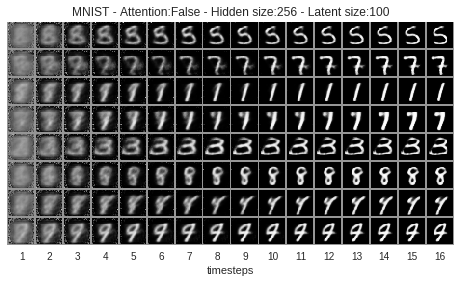

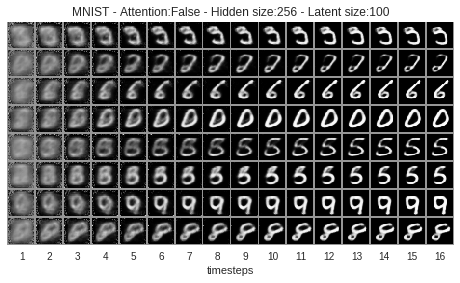

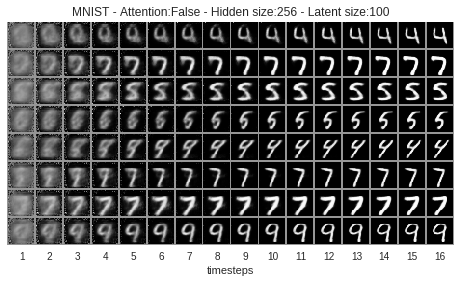

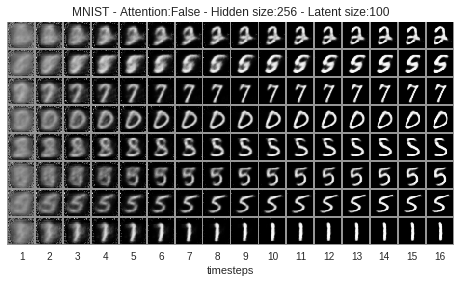

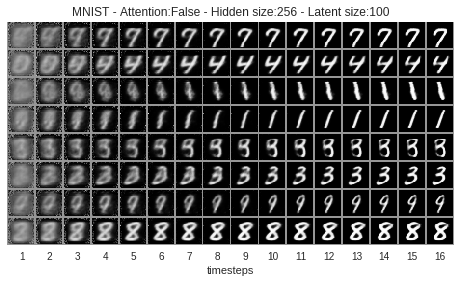

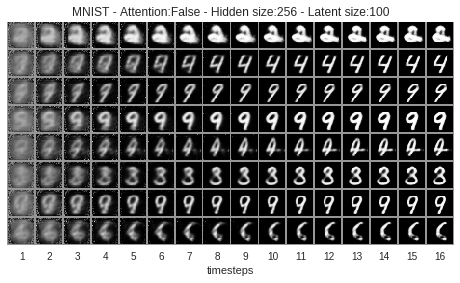

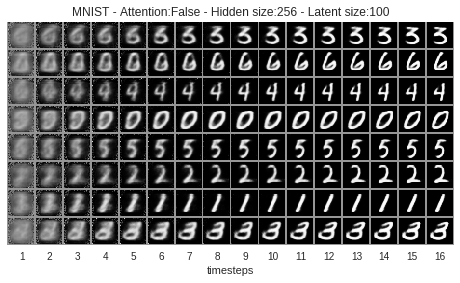

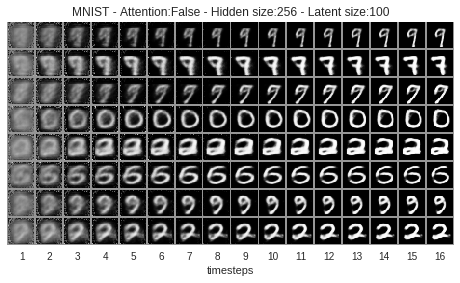

In [362]:
plot_title = 'MNIST - '
for seq in range(int(np.sqrt(mnist_draw_network.batch_size))):
  plot_images(mnist_images[-1][1:], 28, 28, plot_title, mnist_draw_network.attention, seq, network=mnist_draw_network)

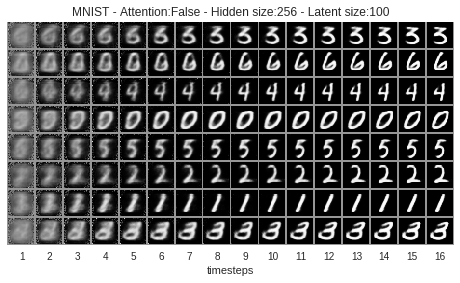

In [365]:
plot_images(mnist_images[-1][1:], 28, 28, plot_title, mnist_draw_network.attention, 6, network=mnist_draw_network)

### Fashion Mnist:

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

T = 16
nb_epochs = 30

fmnist_draw_network = DrawNetwork(T=T, image_size=(1,28,28), nb_h=256, nb_z=100, batch_size=64, N=5, attention=True).cuda()
fmnist_model = DrawModel(fmnist_draw_network, dataset='FashionMNIST')

In [0]:
fmnist_model.load_model(MODEL_PATH + '/FashionMNIST_True_states (2)')

In [0]:
fmnist_images = fmnist_model.model.generate_images().cpu().detach().numpy().reshape((1, 17, 64, 784))

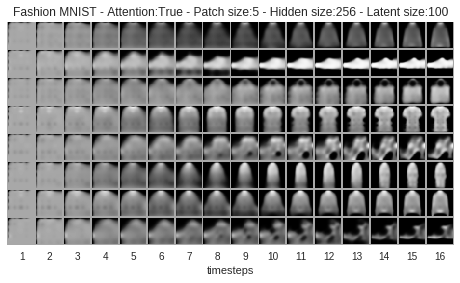

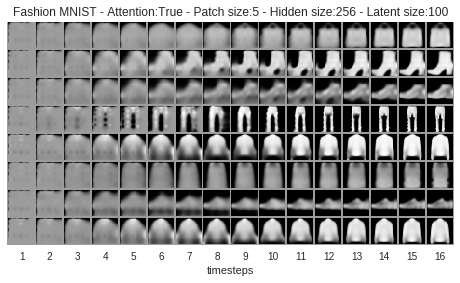

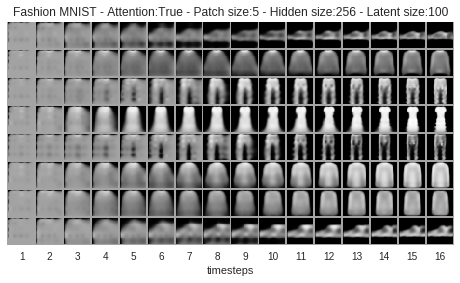

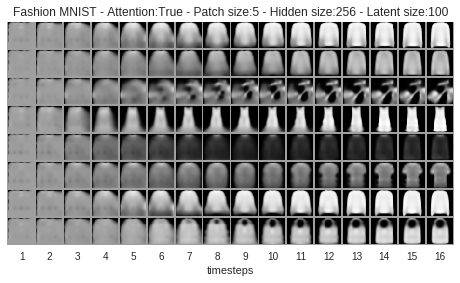

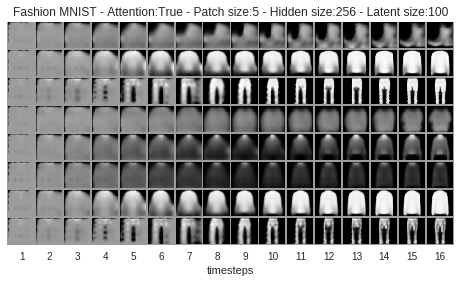

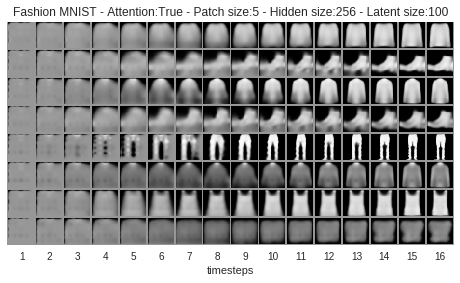

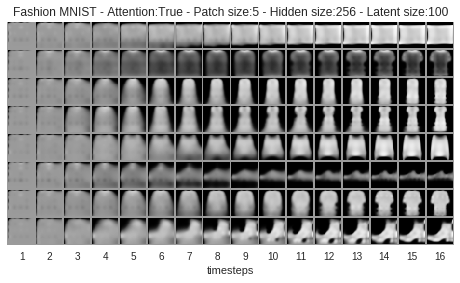

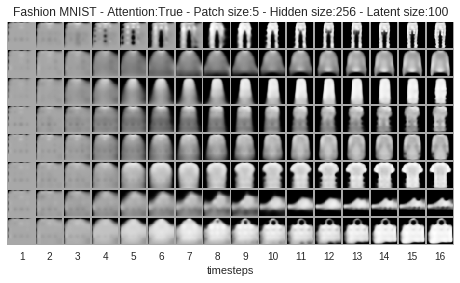

In [160]:
plot_title = 'Fashion MNIST - '
for seq in range(int(np.sqrt(fmnist_draw_network.batch_size))):
  plot_images(fmnist_images[-1][1:], 28, 28, plot_title, fmnist_draw_network.attention, seq, network=fmnist_draw_network)

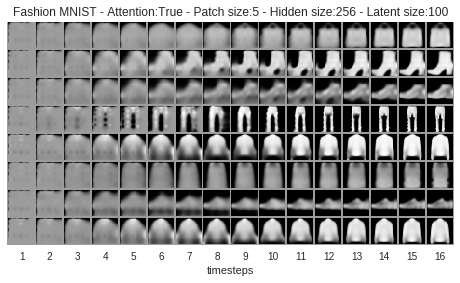

In [161]:
plot_images(fmnist_images[-1][1:], 28, 28, plot_title, fmnist_draw_network.attention, 1, network=fmnist_draw_network)

### SVHN

In [314]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

T = 16
nb_epochs = 30

svhn_draw_network = DrawNetwork(T=T, image_size=(3,32,32), nb_h=800, nb_z=100, batch_size=64, N=12, attention=True).cuda()
svhn_model = DrawModel(svhn_draw_network, dataset='SVHN')

Using downloaded and verified file: ../svhn/train_32x32.mat


In [0]:
svhn_model.load_model(MODEL_PATH + '/SVHN_True_800_100_12_states')

In [340]:
images = svhn_model.model.generate_images().cpu().detach().numpy()
print(images.shape)

(17, 64, 3072)


In [0]:
svhn_images = images.reshape((1, -1, 64, 3, 32, 32))
svhn_images = np.moveaxis(svhn_images, -3, -1)

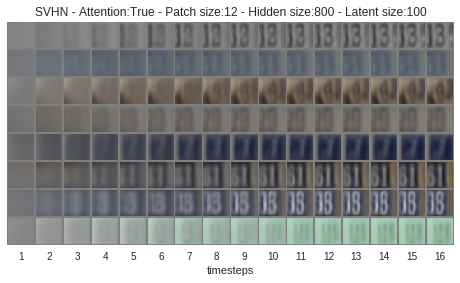

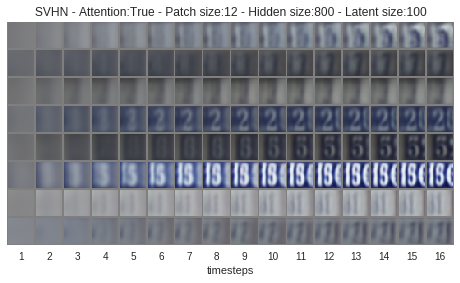

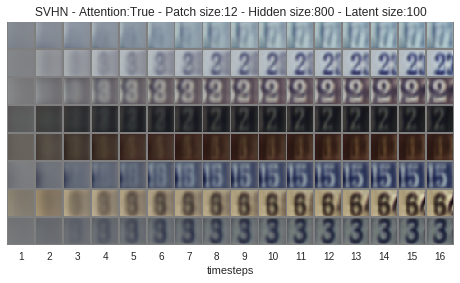

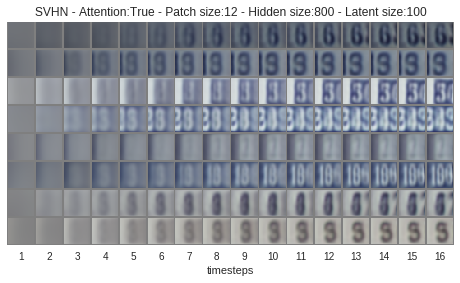

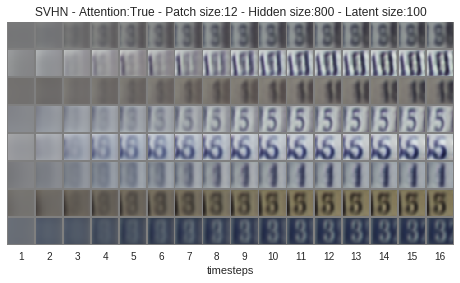

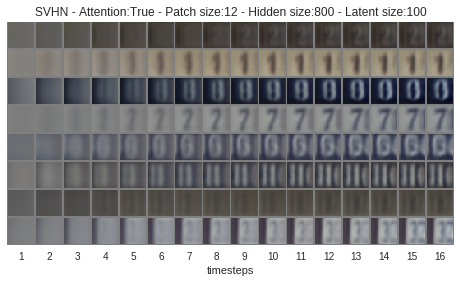

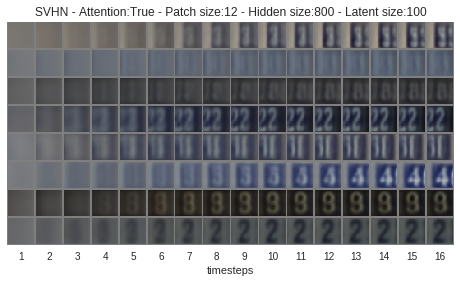

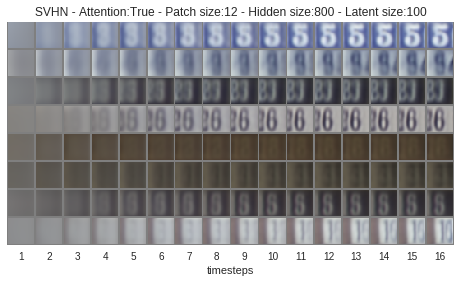

In [369]:
plot_title = 'SVHN - '
for seq in range(int(np.sqrt(svhn_draw_network.batch_size))):
  plot_images_svhn(svhn_images[-1][1:], 32, 32, 3, plot_title, svhn_draw_network.attention, seq, network=svhn_draw_network)

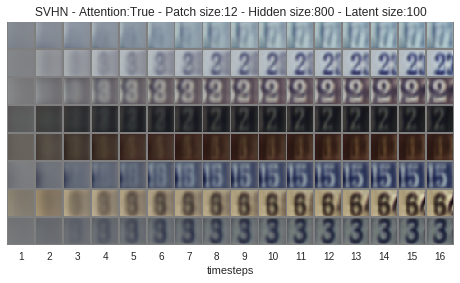

In [343]:
plot_images_svhn(svhn_images[-1][1:], 32, 32, 3, plot_title, svhn_draw_network.attention, 2, network=svhn_draw_network)

In [0]:
def plot_images_svhn(imgs, img_height, img_width, channels, plot_title, attention=False, num_seq=0, padding_width = 1, padding_color = .5, network=None):
  
  patch_height = img_height + 2 * padding_width
  patch_width = img_width + 2 * padding_width
  
  N = int(np.sqrt(len(imgs[0])))
  T = len(imgs)
  
  fig = np.ones((N * patch_width, T * patch_width, channels)) * padding_color
  
  for i in range(N):
    
    v_start = i * patch_height + padding_width
    v_end = v_start + img_height
    
    for t in range(T):
      
      h_start = t * patch_width + padding_width
      h_end = h_start + img_width
      
      fig[v_start:v_end, h_start:h_end] = imgs[t][num_seq * N + i].reshape((img_height, img_width, channels))
  """
  for i in range(N):
    
    v_start = i * patch_height + padding_width
    v_end = v_start + img_height
    
    for j in range(N):
      
      h_start = j * patch_width + padding_width
      h_end = h_start + img_width
      
      fig[v_start:v_end, h_start:h_end] = imgs[-1][N * i + j].reshape((img_height, img_width, channels))
      """

  ax = plt.subplot()
  plt.grid(False)
  plot_title += 'Attention:' + str(network.attention)
  if network.attention: plot_title += ' - Patch size:' + str(network.N)
  plot_title += ' - Hidden size:' + str(network.nb_h)
  plot_title += ' - Latent size:' + str(network.nb_z)
  plt.title(plot_title)
  plt.xlabel('timesteps')
  plt.xticks(np.arange(T) * patch_width + int(patch_width / 2), [str(x) for x in range(1, T+1)])
  plt.yticks([])
  plt.imshow(fig)
  plt.savefig(plot_title.replace(' ', '_') + '.eps', bbox_inches='tight')
  plt.show()